In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Introduction

This notebook implements Logistic Regression for the two-class problem.
The steps are:
    - generate a synthetic dataset, pre-split into train/val/test sets.
    - create a LogisticRegression class to implement Logistic Regression.
    - Train the classifier
    - evaluate its performance.

In [2]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def synthetic_dataset(n_features, n_train, n_val, n_test):
    '''
    n_features: number of input features
    n_train, n_val, n_test : number of train, validation and test examples.
    The function generates binary (0/1) labels.
    '''
    np.random.seed(42)
    
    true_w = np.random.randn(n_features,1)
    true_b = np.random.randn(1)
    
    X_train = np.random.randn(n_features, n_train)
    X_val = np.random.randn(n_features, n_val)
    X_test = np.random.randn(n_features, n_test)
    
    y_train = np.float64(sigmoid(np.dot(true_w.T, X_train) + true_b)>=0.5).reshape(1,-1)
    y_val = np.float64(sigmoid(np.dot(true_w.T, X_val) + true_b)>=0.5).reshape(1,-1)
    y_test = np.float64(sigmoid(np.dot(true_w.T, X_test) + true_b)>=0.5).reshape(1,-1)

    # adding noise
    noise_frac = 0.25
    
    sel_train = np.random.choice(n_train, np.int64(noise_frac*n_train), replace=False) # select the noisy indices
    y_train[0,sel_train] = 1.0 - y_train[0,sel_train]
    sel_val = np.random.choice(n_train, np.int64(noise_frac*n_val), replace=False) # select the noisy indices
    y_train[0,sel_val] = 1.0 - y_train[0,sel_val]
    sel_test = np.random.choice(n_train, np.int64(noise_frac*n_test), replace=False) # select the noisy indices
    y_train[0,sel_test] = 1.0 - y_train[0,sel_test]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = synthetic_dataset(5,2000,1000,1000)

In [4]:
X_train.shape, y_train.shape

((5, 2000), (1, 2000))

In [5]:
class LogisticRegression():

    def __init__(self, GD_num_iter, learning_rate, keep_loss_history, prettify):
        '''
        GD_num_iter -> integer, number of iterations of GD to be done.
        '''
        self._num_features = None
        self._num_examples = None
        self.w = None
        self.b = None
        self.J = None # cost
        
        self.GD_num_iter = GD_num_iter
        self.learning_rate = learning_rate
        self.loss_history = []
        self._keep_loss_history = keep_loss_history
        self._prettify = prettify # show some print statements for progress indications.

        return

    def train(self, X, y):
        '''
        X -> num_features by num_examples array.
        y -> 1 by num_examples array.
        '''
        self._num_features, self._num_examples = X.shape
        assert (y.shape == (1, self._num_examples))
        self.w, self.b = self.__init_params()
        self.__GD(X, y)
        
        return None

    def __init_params(self):
        w = np.zeros((self._num_features, 1))
        b = 0.0
        return w, b

    def __GD(self, X, y):
        
        for i in range(self.GD_num_iter):
    
            # forward propagation
            yhat = sigmoid(np.dot(self.w.T, X)+self.b)
            self.J = self.__cost(yhat, y)
            if (self._keep_loss_history):
                self.loss_history.append(self.J)
            # backward propagation
            dJ_dw = np.dot(X, (yhat-y).T)/self._num_examples
            dJ_db = np.sum(yhat-y)/self._num_examples
            assert(dJ_dw.shape == self.w.shape)
            self.w = self.w - self.learning_rate*dJ_dw
            self.b = self.b - self.learning_rate*dJ_db

            # prettify
            if (self._prettify):
                print(f"Completed iteration {i+1}/{self.GD_num_iter}")
                print(f"Current Loss: {self.J.round(3)}")
                print(f"Current Gradients: dJ_dw = {dJ_dw.round(3)}, dJ_db = {dJ_db.round(3)}")
                print("-------------------------------------------------------------------------")
        
        print("Gradient Descent Complete!")
        print(f"Final Parameters: w = {self.w.round(3)}, b = {self.b.round(3)}, ||dJ_dw|| = {np.linalg.norm(dJ_dw).round(3)}, dJ_db = {dJ_db.round(3)}, J = {self.J.round(3)}")
        # once the iteration is done
        return None
        
    def __cost(self, yhat, y):
        '''
        Compute the binary crossentropy loss averaged over all training examples.
        '''
        assert (yhat.shape == y.shape)
        assert (y.shape == (1, self._num_examples))
        l = -np.sum(y*np.log(yhat) + (1-y)*np.log(1-yhat))/self._num_examples
        return l

    def predict(self, X):
        '''
        make predictions in terms of probability of positive class
        '''
        yhat = sigmoid(np.dot(self.w.T, X)+self.b)
        return yhat    

    ## some helper functions.
    def compute_classification_metrics(self, y_pred, y_true):
        '''
        Compute the precision, recall, F1 score and accuracy.
        '''
        assert (y_pred.shape == y_true.shape)
        accuracy = np.mean(y_pred == y_true)
        true_positives = np.sum((y_pred == 1) * (y_true == 1))
        false_positives = np.sum((y_pred == 1) * (y_true == 0))
        true_negatives = np.sum((y_pred == 0) * (y_true == 0))
        false_negatives = np.sum((y_pred == 0) * (y_true == 1))
    
        precision =  true_positives/(true_positives+false_positives)
        recall = true_positives/(true_positives+false_negatives)
        f1 = 2.0*(precision*recall)/(precision+recall)

        print(f"accuracy: {accuracy.round(3)}")
        print(f"precision: {precision.round(3)}")
        print(f"recall: {recall.round(3)}")
        print(f"F1: {f1.round(3)}")
        
        return None


In [6]:
lr = LogisticRegression(GD_num_iter=5000, learning_rate=0.01, keep_loss_history=True, prettify=False)

In [7]:
lr.train(X_train, y_train)

Gradient Descent Complete!
Final Parameters: w = [[ 0.089]
 [-0.062]
 [ 0.152]
 [ 0.451]
 [-0.081]], b = -0.078, ||dJ_dw|| = 0.0, dJ_db = 0.0, J = 0.662


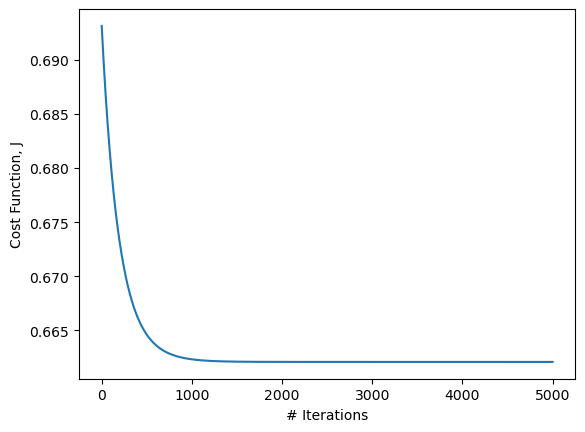

In [8]:
plt.plot(lr.loss_history)
plt.xlabel("# Iterations")
plt.ylabel("Cost Function, J")
plt.show()

##### Observation

We see that the cost function is monotonically decreasing, and hence, the Gradient Descent algorithm does not have any (obvious) bugs.
We can predict the positive-class probabilities for the validation and test set now, as well as use a threshold of 0.5 to predict class labels and compute relevant metrics for classification.

In [9]:
y_val_proba = lr.predict(X_val)
y_val_pred = np.float64(y_val_proba >= 0.5)
y_test_proba = lr.predict(X_test)
y_test_pred = np.float64(y_test_proba >= 0.5)

In [10]:
# for comparison with sklearn results
from sklearn.metrics import precision_recall_fscore_support

In [11]:
lr.compute_classification_metrics(y_val_pred, y_val)
prec_val, rec_val, f1_val, _ = precision_recall_fscore_support(y_val.reshape(-1), y_val_pred.reshape(-1), average='binary')
print("Precision on Validation Set (sklearn):",prec_val.round(3))
print("Recall on Validation Set (sklearn):",rec_val.round(3))
print("F1 score on Validation set (sklearn):", f1_val.round(3))

accuracy: 0.95
precision: 0.956
recall: 0.936
F1: 0.946
Precision on Validation Set (sklearn): 0.956
Recall on Validation Set (sklearn): 0.936
F1 score on Validation set (sklearn): 0.946


In [12]:
lr.compute_classification_metrics(y_test_pred, y_test)
prec_test, rec_test, f1_test, _ = precision_recall_fscore_support(y_test.reshape(-1), y_test_pred.reshape(-1), average='binary')
print("Precision on Test Set (sklearn):",prec_test.round(3))
print("Recall on Test Set (sklearn):",rec_test.round(3))
print("F1 score on Test set (sklearn):", f1_test.round(3))

accuracy: 0.945
precision: 0.948
recall: 0.924
F1: 0.936
Precision on Test Set (sklearn): 0.948
Recall on Test Set (sklearn): 0.924
F1 score on Test set (sklearn): 0.936


##### Note

As we can see, the values match up, so there is no error in the implementation of this function.
Finally, we can compare the performance of our implemented class with sklearn.

In [13]:
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression

In [14]:
sk_lr = sk_LogisticRegression(penalty=None, max_iter=5000, n_jobs=-1)

In [15]:
sk_lr.fit(X_train.T, y_train.reshape(-1))

LogisticRegression(max_iter=5000, n_jobs=-1, penalty=None)

In [16]:
y_val_pred_sk = sk_lr.predict(X_val.T)
prec_val_sk, rec_val_sk, f1_val_sk, _ = precision_recall_fscore_support(y_val.reshape(-1), y_val_pred_sk.reshape(-1), average='binary')
print("Precision on Validation Set (sklearn model):",prec_val_sk.round(3))
print("Recall on Validation Set (sklearn model):",rec_val_sk.round(3))
print("F1 score on Validation set (sklearn model):", f1_val_sk.round(3))

Precision on Validation Set (sklearn model): 0.956
Recall on Validation Set (sklearn model): 0.936
F1 score on Validation set (sklearn model): 0.946


In [17]:
y_test_pred_sk = sk_lr.predict(X_test.T)
prec_test_sk, rec_test_sk, f1_test_sk, _ = precision_recall_fscore_support(y_test.reshape(-1), y_test_pred_sk.reshape(-1), average='binary')
print("Precision on Test Set (sklearn model):",prec_test_sk.round(3))
print("Recall on Test Set (sklearn model):",rec_test_sk.round(3))
print("F1 score on Test set (sklearn model):", f1_test_sk.round(3))

Precision on Test Set (sklearn model): 0.948
Recall on Test Set (sklearn model): 0.924
F1 score on Test set (sklearn model): 0.936


## Applying the LogisticRegression class on the Breast Cancer Dataset

#### Note

As we can see, the performance is nearly identical, thus, the class written above performs well, without any bugs!

In [29]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [60]:
def breast_cancer_detection():
    '''
    Apply the LogisticRegression classifier to the breast cancer dataset in sklearn
    '''
    dataset = load_breast_cancer()
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).T
    X_test = scaler.transform(X_test).T
    y_train = y_train.reshape(1,-1)
    y_test = y_test.reshape(1, -1)
    
    lr = LogisticRegression(GD_num_iter=10_000, learning_rate=0.1, keep_loss_history=True, prettify=False)
    lr.train(X_train, y_train)
    plt.plot(lr.loss_history)
    plt.xlabel("# Iterations")
    plt.ylabel("Cost Function, J")
    plt.show()
    y_test_proba = lr.predict(X_test)
    y_test_pred = np.float64(y_test_proba >= 0.5)
    lr.compute_classification_metrics(y_test_pred, y_test)

Gradient Descent Complete!
Final Parameters: w = [[-5.310e-01]
 [-5.540e-01]
 [-4.530e-01]
 [-6.520e-01]
 [-2.380e-01]
 [ 1.607e+00]
 [-8.220e-01]
 [-9.920e-01]
 [ 1.000e-03]
 [ 1.270e-01]
 [-1.930e+00]
 [ 5.100e-01]
 [-8.440e-01]
 [-1.641e+00]
 [-2.390e-01]
 [ 9.620e-01]
 [ 2.690e-01]
 [-7.520e-01]
 [ 5.920e-01]
 [ 6.840e-01]
 [-1.457e+00]
 [-2.114e+00]
 [-1.081e+00]
 [-1.544e+00]
 [-1.282e+00]
 [ 2.540e-01]
 [-1.382e+00]
 [-1.484e+00]
 [-1.640e+00]
 [-2.680e-01]], b = 0.029, ||dJ_dw|| = 0.002, dJ_db = 0.0, J = 0.042


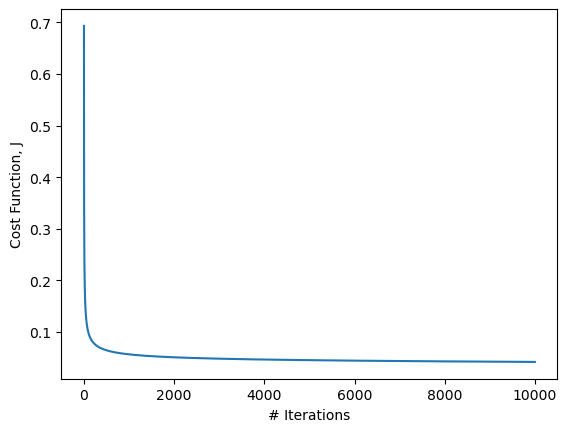

accuracy: 0.982
precision: 0.986
recall: 0.986
F1: 0.986


In [61]:
breast_cancer_detection()